**IMPORT DEPENDENCIES**

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
import warnings
warnings.filterwarnings("ignore")

**PARAMETERS**

In [2]:
USE_DATA_LEAK='Y' ## Set to Y to exploit data leak

RAND_VAL=42
num_folds=5 
n_est=3500 

**READ TEST AND TRAIN FILES FROM THE DATASET**

In [3]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
print(df_train.columns)
df_train.head()

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [4]:
df_test = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')
df_test_ov = df_test.copy()
df_test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


**SCALING**

In [5]:
scale_cols = ['Age','CreditScore', 'Balance','EstimatedSalary']

for c in scale_cols:
    min_value = df_train[c].min()
    max_value = df_train[c].max()
    df_train[c+"_scaled"] = (df_train[c] - min_value) / (max_value - min_value)
    df_test[c+"_scaled"] = (df_test[c] - min_value) / (max_value - min_value)

**FEATURE ENGINEERING**

In [6]:
def getFeats(df):
    
    df['IsSenior'] = df['Age'].apply(lambda x: 1 if x >= 60 else 0)
    df['IsActive_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']
    df['Products_Per_Tenure'] =  df['Tenure'] / df['NumOfProducts']
    df['AgeCat'] = np.round(df.Age/20).astype('int').astype('category')
    df['Sur_Geo_Gend_Sal'] = df['Surname']+df['Geography']+df['Gender']+np.round(df.EstimatedSalary).astype('str')
    
    return df

In [7]:
df_train = getFeats(df_train)
df_test = getFeats(df_test)

feat_cols=df_train.columns.drop(['id','Exited'])
feat_cols=feat_cols.drop(scale_cols)
print(feat_cols)
df_train.head()

Index(['CustomerId', 'Surname', 'Geography', 'Gender', 'Tenure',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Age_scaled',
       'CreditScore_scaled', 'Balance_scaled', 'EstimatedSalary_scaled',
       'IsSenior', 'IsActive_by_CreditCard', 'Products_Per_Tenure', 'AgeCat',
       'Sur_Geo_Gend_Sal'],
      dtype='object')


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,Exited,Age_scaled,CreditScore_scaled,Balance_scaled,EstimatedSalary_scaled,IsSenior,IsActive_by_CreditCard,Products_Per_Tenure,AgeCat,Sur_Geo_Gend_Sal
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,...,0,0.202703,0.636,0.000000,0.907279,0,0.0,1.5,2,OkwudilichukwuFranceMale181450.0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,...,0,0.202703,0.554,0.000000,0.247483,0,1.0,0.5,2,OkwudiliolisaFranceMale49504.0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,...,0,0.297297,0.656,0.000000,0.924364,0,0.0,5.0,2,HsuehFranceMale184867.0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,...,0,0.216216,0.462,0.593398,0.422787,0,1.0,2.0,2,KaoFranceMale84561.0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,...,0,0.202703,0.732,0.000000,0.075293,0,1.0,2.5,2,ChiemenamSpainMale15069.0


In [8]:
X=df_train[feat_cols]
y=df_train['Exited']
##
cat_features = np.where(X.dtypes != np.float64)[0]
cat_features

array([ 0,  1,  2,  3,  4,  5, 12, 15, 16])

**TRAINING**

In [9]:
folds = StratifiedKFold(n_splits=num_folds,random_state=RAND_VAL,shuffle=True)
test_preds = np.empty((num_folds, len(df_test)))
auc_vals=[]

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[valid_idx], y.iloc[valid_idx]
    
    train_pool = Pool(X_train, y_train,cat_features=cat_features)
    val_pool = Pool(X_val, y_val,cat_features=cat_features)
    
    clf = CatBoostClassifier(
    eval_metric='AUC',
    learning_rate=0.03,
    iterations=n_est)
    clf.fit(train_pool, eval_set=val_pool,verbose=300)
    
    y_pred_val = clf.predict_proba(X_val[feat_cols])[:,1]
    auc_val = roc_auc_score(y_val, y_pred_val)
    print("AUC for fold ",n_fold,": ",auc_val)
    auc_vals.append(auc_val)
    
    y_pred_test = clf.predict_proba(df_test[feat_cols])[:,1]
    test_preds[n_fold, :] = y_pred_test
    print("-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-")

0:	test: 0.8664503	best: 0.8664503 (0)	total: 246ms	remaining: 14m 19s
300:	test: 0.8952332	best: 0.8952332 (300)	total: 51.3s	remaining: 9m 5s
600:	test: 0.8967099	best: 0.8967100 (599)	total: 1m 40s	remaining: 8m 6s
900:	test: 0.8971909	best: 0.8971909 (900)	total: 2m 31s	remaining: 7m 17s
1200:	test: 0.8973670	best: 0.8973750 (1194)	total: 3m 21s	remaining: 6m 25s
1500:	test: 0.8975594	best: 0.8975634 (1493)	total: 4m 11s	remaining: 5m 35s
1800:	test: 0.8976274	best: 0.8976326 (1795)	total: 5m 2s	remaining: 4m 45s
2100:	test: 0.8976393	best: 0.8976629 (2025)	total: 5m 53s	remaining: 3m 55s
2400:	test: 0.8975894	best: 0.8976629 (2025)	total: 6m 44s	remaining: 3m 5s
2700:	test: 0.8975643	best: 0.8976629 (2025)	total: 7m 35s	remaining: 2m 14s
3000:	test: 0.8974979	best: 0.8976629 (2025)	total: 8m 26s	remaining: 1m 24s
3300:	test: 0.8974024	best: 0.8976629 (2025)	total: 9m 18s	remaining: 33.7s
3499:	test: 0.8974063	best: 0.8976629 (2025)	total: 9m 52s	remaining: 0us

bestTest = 0.897662

**EVALUATION**

In [10]:
"Mean AUC: ",np.mean(auc_vals)

('Mean AUC: ', 0.89818530170557)

**FEATURE IMPORTANCE**

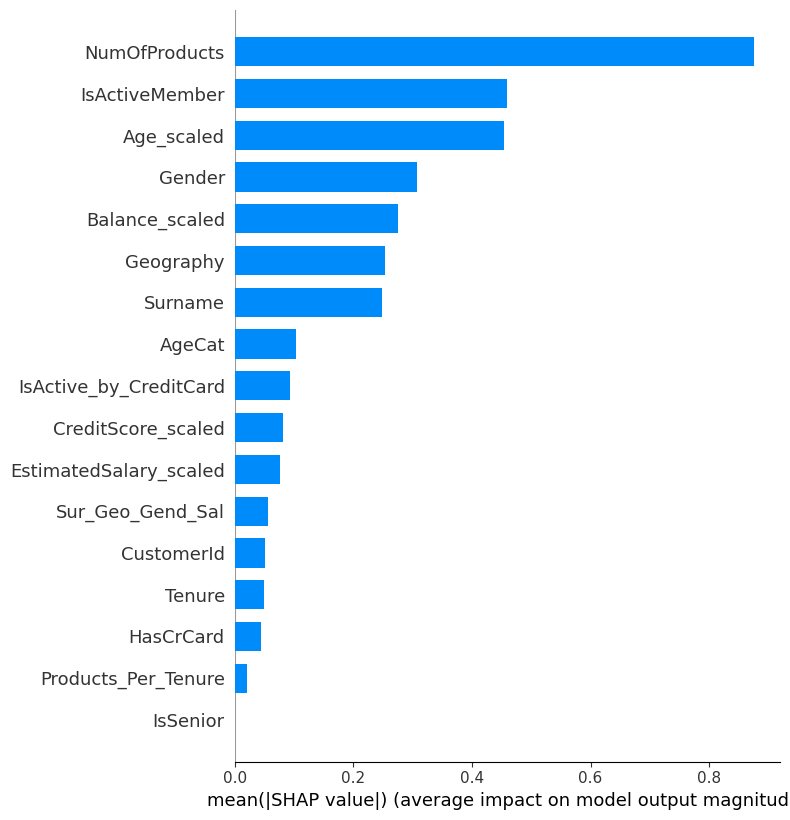

In [11]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(train_pool)
shap.summary_plot(shap_values, X_train, plot_type="bar")

**PREDICTION AND SUBMISSION**

In [12]:
y_pred = test_preds.mean(axis=0)
df_orig=pd.read_csv("/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv")
join_cols=list(df_orig.columns.drop(['RowNumber','Exited']))
df_orig.rename(columns={'Exited':'Exited_Orig'},inplace=True)
df_orig['Exited_Orig']=df_orig['Exited_Orig'].map({0:1,1:0})
df_test_ov=df_test_ov.merge(df_orig,on=join_cols,how='left')[['id','Exited_Orig']].fillna(-1)
####
df_sub = df_test_ov[['id','Exited_Orig']]

if USE_DATA_LEAK=='Y':
    df_sub['Exited'] = np.where(df_sub.Exited_Orig==-1,y_pred,df_sub.Exited_Orig)
else:
    df_sub['Exited'] = y_pred
    
df_sub.drop('Exited_Orig',axis=1,inplace=True)
df_sub.head()

,id,Exited
0,165034,0.012989
1,165035,0.842677
2,165036,0.013685
3,165037,0.195689
4,165038,0.429987


In [13]:
df_sub.to_csv("submission.csv",index=False)

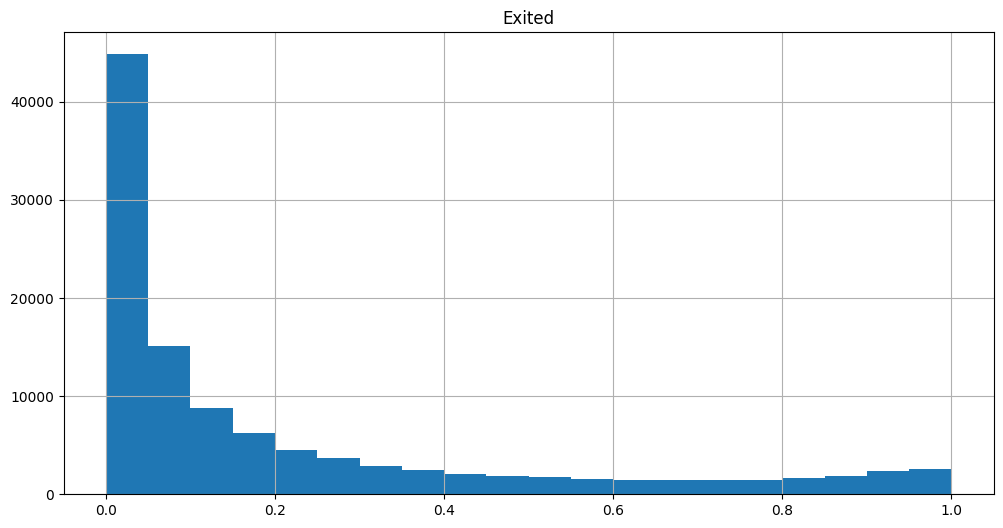

In [14]:
df_sub.hist(column='Exited', bins=20, range=[0,1],figsize=(12,6))
plt.show()